In [14]:
import numpy as np
import scipy as sp

import h5py
import natsort
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from functools import partial

from jax import jit

import jax
import jax.numpy as jnp
import time
import jax.scipy.optimize

# this is the package to solve
import jax_fd
import near_field

In [2]:
# size of the domain in x and y
ax = 1.0
ay = 1.0

# number of discretization points per dimension
nxi = 80
nyi = nxi

# PML
npml = 20
sigmaMax = 80

nx = nxi + 2*npml
ny = nx

# we choose to have 4 points per wavelenght
#omega = 2*jnp.pi*nyi/10;
omega = 2*jnp.pi*2.5
order = 2

# grid spacing
hx = 1/(nxi-1)

sampling_radius = 1.0
n_angles = nxi


In [3]:
# initialize the parameters
params_nf = near_field.init_params_near_field(ax, ay, nxi, nyi,npml,
                                         sampling_radius,
                                         n_angles, omega, sigmaMax)

In [4]:
# definition of the perturbation by the lense
def perturbation(x,y):
    return (0.2*sp.stats.norm.pdf(x,0.1,5*hx)*sp.stats.norm.pdf(y,0.1,5*hx))
    #return    1.0*np.exp(-50*(np.square(x-0.1) + np.square(y-0.1)))\
            #+ 1.0*np.exp(-500*(np.square(x-0.1) + np.square(y-0.1)))\
            #+ 1.0*np.exp(-500*(np.square(x-0.15) + np.square(y+0.3)))

# we sample the perturbation
eta = perturbation(params_nf.fd_params.Xi, params_nf.fd_params.Yi) 
m = 1 + eta
eta_vect = np.reshape(eta, (-1,))
m_vect = np.reshape(m, (-1,))

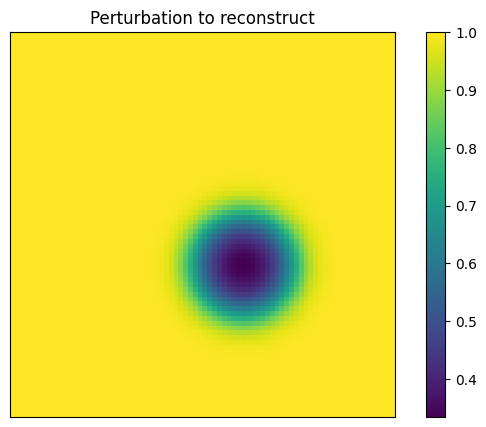

In [5]:
plt.figure(figsize=(8,5))
plt.imshow(1/jnp.sqrt(m_vect).reshape((nxi,nyi)))
plt.xticks([]); plt.yticks([]);
plt.title('Perturbation to reconstruct', color='black')
plt.colorbar()
plt.show()

In [6]:
eta_ext = near_field.ExtendModel(eta, nxi, nyi, npml)
m_ext = near_field.ExtendModel(m, nxi, nyi, npml)

In [7]:
tol = 1e-02
#H = jax_fd.HelmholtzMatrix(m_ext, params_nf.fd_params.nx, params_nf.fd_params.ny,
#                           params_nf.fd_params.npml, params_nf.fd_params.h,
#                           params_nf.fd_params.SigmaMax, order, omega, 'compact_explicit')
H = jax_fd.HelmholtzMatrix_off_diag(params_nf.fd_params.nx, params_nf.fd_params.ny,
                                    params_nf.fd_params.npml, params_nf.fd_params.h,
                                    params_nf.fd_params.SigmaMax, order, omega)

In [8]:
near_field_ = near_field.NearField(H, omega, params_nf, tol)
near_field_jit = jit(near_field_())

In [9]:
field = near_field_jit(eta_ext)

In [10]:
Lambda = near_field.smoothing_solution(field, params_nf, n_angles, sampling_radius)

In [11]:
field.shape

(14400, 80)

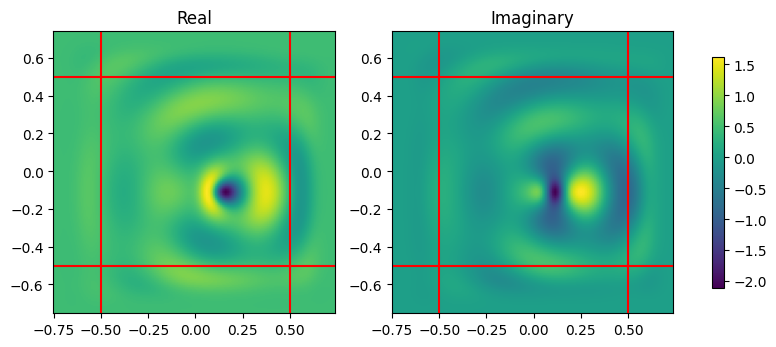

In [12]:
near_field.DisplayField(field[:,0],params_nf.fd_params.x,params_nf.fd_params.y, npml)

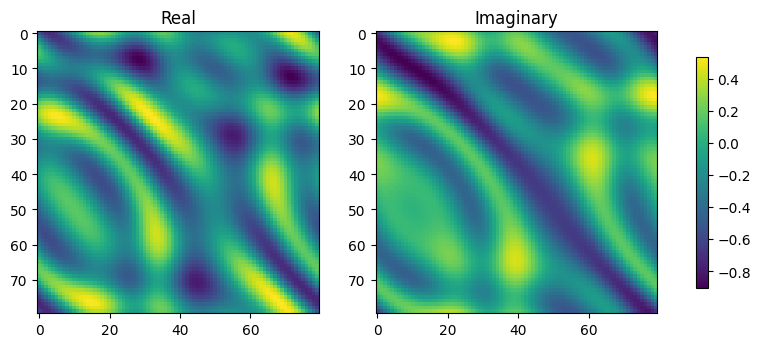

In [13]:
near_field.DisplayField(Lambda, params_nf.fd_params.xi,params_nf.fd_params.yi)

In [15]:
projection_mat = near_field.get_projection_mat(params_nf, n_angles, sampling_radius)

In [15]:
eta_0 = 0*eta_vect

In [16]:
misfit_ = near_field.MisFit(H, omega, params_nf, order, tol, Lambda, projection_mat)
misfit_jit = jit(misfit_())

In [22]:
f, grad_f = misfit_jit(eta_0)

In [18]:
grad_misfit_ = near_field.GradMisFit(H, omega, params_nf, order, tol, Lambda, projection_mat)
grad_misfit_jit = jit(grad_misfit_())

In [19]:
grad_f = grad_misfit_jit(eta_0)

In [ ]:
#opt_eta = sp.optimize.minimize(near_field.misfit, eta_0, args=(params_nf, projection_mat, Lambda, order), method='BFGS', jac=True, options={'disp': True, 'maxiter': 100})

In [16]:
Lambda.shape

(80, 80)

In [17]:
Lambda

Array([[-0.2573421 -0.7156357j , -0.337191  -0.6238386j ,
        -0.39040756-0.51535743j, ...,  0.09079216-0.8280403j ,
        -0.03633301-0.82374394j, -0.15493257-0.7832463j ],
       [-0.14412124-0.8028618j , -0.24222659-0.7408763j ,
        -0.32032537-0.6555337j , ...,  0.20357709-0.8091426j ,
         0.08666152-0.8400081j , -0.03200453-0.83586854j],
       [-0.02790176-0.85107034j, -0.13318329-0.822715j  ,
        -0.2264357 -0.7670706j , ...,  0.28670028-0.7595418j ,
         0.18974811-0.81952584j,  0.08225468-0.84900707j],
       ...,
       [-0.43777233-0.29196703j, -0.41872644-0.16723466j,
        -0.37008926-0.05457175j, ..., -0.28811163-0.6529095j ,
        -0.37347192-0.5455292j , -0.42332578-0.42052436j],
       [-0.4152406 -0.44845924j, -0.43293905-0.32290187j,
        -0.4186928 -0.19955978j, ..., -0.17071766-0.75016916j,
        -0.2818597 -0.6722237j , -0.3644564 -0.5672461j ],
       [-0.35214883-0.5941989j , -0.40420222-0.4802037j ,
        -0.42536587-0.35839763